# Seismic Data Processing and HVSR

# Introduction

Seismology is one of the oldest and largest branches of geophysics. 
Seismic data is somewhat unique in its breadth of application: from planet-scale studies to hyper-local site characterization. In large part because of the global nature of seismic phenomena and because of the highly destructive potential of earthquakes, seismic data is highly organized and is shared globally. Countries develop their own seismometer networks, the data from which are often available to be downloaded or "streamed" online. Seismic data has many national security implications: it is used to detect nuclear tests, monitor border crossings, and explore for mineral or oil resources.

Seismic data (as well as HVSR specifically, which we will focus on here) is also one of the only types of data collected on Earth, the Moon, and Mars.

A basic understanding of seismic data, processing, and terminology is often expected in most roles having to do with geopysics.
Environmental applications of seismic geophysical data are not as common as, for example, GPR and ERT.
Understanding how to work with seismic data is still important for those working in environmental geophysics for a number of reason:
* Seismic data and terminology can be used in many environmental applications
* Many of the processing techniques used in GPR are directly analogous to (if not exactly the same as) techniques developed for seismology
* Seismic data have many near-surface applications that will often overlap with environmental investigations

## Seismic Data

Seismic data is at its core time-series data, and many of the processing techniques used in seismology are analagous to (if not exactly the same as) techniques used in and developed for broader signal processing algorithms.

You should have an understanding of basic seismic terminology, but some terms worth emphasizing are included below:

### General seismological terms:

* **Seismometer**: an instrument that measures seismic data
* **Seismic Network**: a collection of seismic stations, often managed by a single entity and with a singular purposes
* **Seismic Station**: a seismometer (or multiple seismometers) that has been given a specific identifying code. Often, this is formatted as follows:
    * NETWORK_NAME.STATION_NAME.LOCATION.CHANNEL
* **Channel**: Often, the basic data feed or measurement coming out of a seismometer (or similar instrument). Many seismometer have more than one channel.
    * These channels often consist of data read from a single geophone
    * Among the most common configurations is a three-component seismometer: a vertical geophone, a horizontal geophone facing "East", and an orthogonal horizontal geophone facing "north"
* **Geophone**: a device contained within a seismometer that measures ground motion
    * The data from a geophone is often recorded as one channel in a seismometer's data record
* **Component**: Often used interchangeably with "channel", but more specifically refers to directionality of the geophone
    * The term **channel** implies a single set of data from a single geophone with consistent parameters

### Terms or classes with a specific usage in Obspy
* **Trace**: the basic building block of seismic data in Obspy
    * A trace is a class in obspy that consists of a single stream of data and its associated metadata
    * The time component of an obspy trace is always in UTC time
    * Traces can have gaps in time, which can either be "merged" as a single trace with a "masked" array or "split" into multiple traces.
    * Much of a trace's metadata is contained in its "stats" attribute
* **Stream**: a collection of seismic data in Obspy, often the most basic data type read in from a real data source
    * Streams consist of multiple traces. For example, the data from a three component seismometer ideally consists of three traces collected into in a single stream
    * Most of the obspy functions or methods that work on streams actually perform on the individual traces in the stream.
* **UTC**: "Universal time coordinates," similar to an official scientific "time zone"
    * For the most part, it is aligned with Greenwich Mean Time (i.e., the time in England)
    * In obspy, these time coordinates are implented as `UTCDateTime` objects
    * `UTCDateTime` is a class to standardize the time dimension of seismic data, but also has varous methods and attributes that allow manipulation from other common python time objects (such as objects in the Datetime module of the python standard library and matplotlib times for plotting)

# Seismic Data: Data in time

One of the most important aspects of seismic data is the time dimension. In fact, modern seismology depends almost entirely on the ability to accurately and precisely measure when ground motion occured. It is perhaps as important as the magnitude of the ground motion itself.

In order to work with time, we should first try understand the objects used for time in python.

There was a relatively large change in how python deals with time natively that was released with python version 3.9, so please ensure you have version 3.9 or greater installed.

The primary time and date module in python's standard library is called `datetime`. The following is a non-comprehensive overview of python packages that deal with time:

### Standard library (installed with python itself)
* **datetime**: The primary python module for creating and dealing with dates and times
    * **date**: similar to and compatible with datetime, but only uses dates
    * **time**: simliar to and compatible with datetime, but only deals with times
    * **tzinfo**: module for creating timezone objects, converting between timezones, etc.
        * **timezone**: class for working with timezones and offsets from UTC, for example
    * **timedelta**: module for getting the difference between two datetime values


### 3rd-Party Libraries
* **pytz**: installed as a dependency in pandas, pytz brings the [Olson (or IANA) timezone database](https://en.wikipedia.org/wiki/Tz_database) into Python
* **tzdata**: a python data-only package that provides access to [Internet Assigned Numbers Authority (IANA) timezone database](https://www.iana.org/time-zones)
* **matplotlib.pyplot.time**: submodule of matplotlib's pyplot that allows manipulation of time
* **UTCDateTime**: a module of the obspy package, this is the primary object used to represent time in obspy


Let's first familiarize ourselves with the datetime module.

The datetime module contains several submodules. One is also called `datetime`. The `date` and `time` submodules are, to put it in a simple way, essentially one half each of the `datetime` class. (technically, `datetime` is a subclass of the `date` class)

You can create a time object (at midnight: 00:00:00) with the following code. You can add arguments for hours, minutes, seconds, microseconds, and timezone information.

In [106]:
import datetime
# Create a time object at midnight
midnightTime = datetime.time()
#this is the same as datetime.time(hour=0, minute=0, second=0, microsecond=0)
print(midnightTime)
oneSecond5MicrosAfterMidnight = datetime.time(hour=0, minute=0, second=1, microsecond=5)
print(oneSecond5MicrosAfterMidnight)
midnightTime

00:00:00
00:00:01.000005


datetime.time(0, 0)

Now, that may be useful enough, but...which midnight do we mean (i.e., where on earth?). This is not specified by default with native datetime objects, but we can make these objects timezone-aware.

In [154]:
import datetime
import zoneinfo
usc = zoneinfo.ZoneInfo('US/Central') #"US/Central" is the IANA name for 
uscMidnight = datetime.time(tzinfo=usc)
uscMidnight

datetime.time(0, 0, tzinfo=zoneinfo.ZoneInfo(key='US/Central'))

A printout of available timezones can be printed using the following code (this is a set of officially-recognized timezone names):

In [ ]:
import zoneinfo
zoneinfo.available_timezones()

There is actually more that can be done on `datetime.datetime` objects with timezones. 

For example, let's say that we acquire data in the field using our local time (e.g., Central Time in the U.S.).

However, our seismic data is likely to be in UTC. If we want to programatically "translate" this time, we can do so! Let's first define a `datetime` object in our local ('US/Central' in this case) timezone.

In [135]:
import datetime
import zoneinfo
# First, define the date and timezone
usc = zoneinfo.ZoneInfo('US/Central')

# specifying tzinfo makes datetimes timezone-aware
oct102010=datetime.datetime(2010, 10, 10, 5, 10, tzinfo=usc)
# same as: oct102010=datetime.datetime(year=2010, month=10, day=10, hour=5, minute=10, tzinfo=usc)

print(oct102010)
oct102010

2010-10-10 05:10:00-05:00


datetime.datetime(2010, 10, 10, 5, 10, tzinfo=zoneinfo.ZoneInfo(key='US/Central'))

Now, let's convert that timezone-aware datetime object to UTC

In [136]:
oct102010UTC = oct102010.astimezone(zoneinfo.ZoneInfo('UTC'))
print(oct102010UTC)
oct102010UTC

2010-10-10 10:10:00+00:00


datetime.datetime(2010, 10, 10, 10, 10, tzinfo=zoneinfo.ZoneInfo(key='UTC'))

We are able (only relatively recently) to get `datetime` objects from the standard library specifically into UTC.

Even so, python's native datetime module is not the most robust or intuitive for specifying times in UTC, which is very important for seismic data!

So, the Obspy module has its own class for keeping track of datetimes to avoid this confusion (and to add useful functionality). This class is called `UTCDateTime`.

For example, rather than microsecond precision out of the box, the `UTCDateTime` has nanosecond precision. There is also no confusion as to what timezone the time data is in, since it is always in UTC.

`UTCDateTime` can be called similarly to the native python `datetime.datetime` class (i.e., by specifying year, month, day, etc.), but it also has many more options to maintain compatibility with a variety of seismic systems.

For example, one of the more commonly used alternative date specifiers is called the "Julian day" which in this case essentially means the day of the year (e.g., Feb 1 would be the 32nd day of the year). The Julian Day can be used both for input and out output of `UTCDateTime` objects.

Obspy's UTCDateTime can easily determine this value, see below:

In [151]:
import obspy
oct102010UTCDT = obspy.UTCDateTime(2010, 10, 10, 5, 10)
print(oct102010UTCDT.julday)

283


Ok, practice on your own. We want to create a `UTCDateTime` object for the due date and time of this assignment (March 2, 2025 at 11:59pm and 59 seconds and  999,999 microseconds CENTRAL TIME).

First, create a timezone-aware datetime object 

In [232]:
import datetime
import zoneinfo
centralDT = datetime.datetime(2025, 3, 2, 23, 59, 59, 999999, tzinfo=zoneinfo.ZoneInfo("US/Central"))
obspy.UTCDateTime(centralDT)

2025-03-03T05:59:59.999999Z

Now, translate it to a timezone of your choice (can be your home timezone if that is different than "US/Central", UTC, or whatever you choose!)

In [ ]:
# Convert the time to a timezone of your choice!


# Data in traces and streams

Now, let's take a look at how data is stored and organized in obspy.

You can read a short, sample dataset using obspy using `obspy.read()`. 

Normally, we would enter a filepath between the parentheses of the `read()` function. If we leave it blank, we will get a sample dataset.

Read in that sample data stream below.

In [187]:
import obspy
sampleStream = obspy.read()

There are a few different ways to see what our dataset looks like. One is to simply print the string representation of the obspy Stream object.

This will give a heading with the number of traces in the stream, and a brief summary of each stream.

In [189]:
print(sampleStream)

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


When you iterate through a Stream object (using a `for` loop, for example), it will go through each Trace object contained in the Stream object.

This looks similar to printing the Stream object, but it does not contain the "header".

In [191]:
# Loop through traces
for trace in sampleStream:
    print('TRACE INFORMATION:', trace)

TRACE INFORMATION: BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
TRACE INFORMATION: BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
TRACE INFORMATION: BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


You can also simply plot a stream, which will produce an individual subplot for each trace.

Setting it equal to a variable will save the matplotlib figure into that variable.

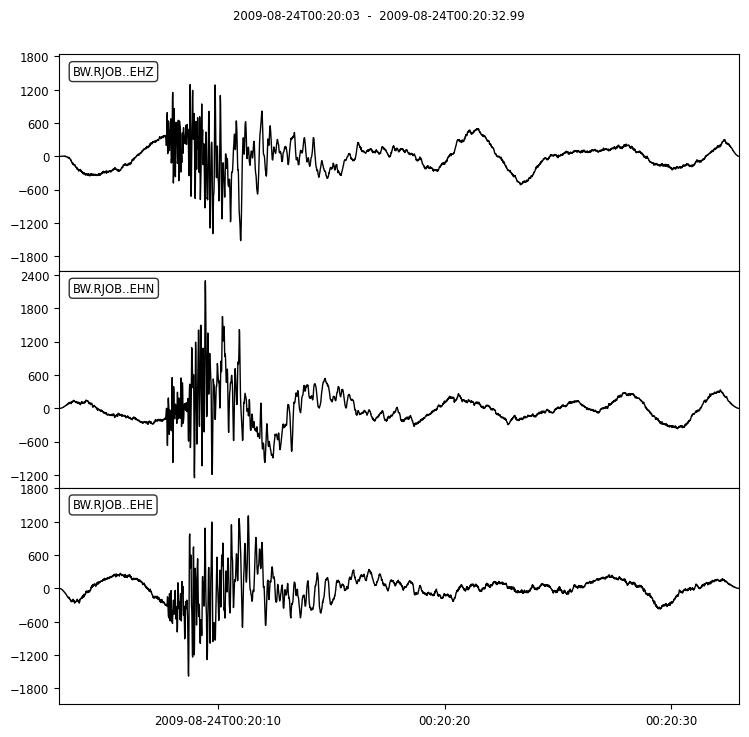

In [193]:
samplePlot = sampleStream.plot()


Now, if we want to extract a specific trace from the stream, we have a few options.

You can using indexing, just as if the traces were in a list. Note the data type this returns (i.e., an obspy Trace)

In [196]:
firstTrace = sampleStream[0]
zTrace = firstTrace # This just happens to be the Z trace
print(type(zTrace))
print(zTrace)

<class 'obspy.core.trace.Trace'>
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


We can also use the `.select()` method of the obspy streams to select all traces (only one in this instance) with a specific parameter.

In this case, we'll select all traces in our stream from the "EHE" channel. (There can be multiple EHE channel traces if, for example, there is a large time gap in the data or if there are multiple stations' stream in the Stream object you are using). 

You can select using many attributes via the `.select()` method. In this case, we are selecting using the "channel" attribute.

Note the data type that the `.select()` method returns (i.e., an obspy Stream). Even though there is only one Trace in this Stream, the `.select()` method returns a Stream. 

Later, we can use the indexing selection again to isolate a trace as needed.

In [197]:
eTraceStream = sampleStream.select(channel='EHE')
print(type(eTraceStream))
print(eTraceStream)

<class 'obspy.core.stream.Stream'>
1 Trace(s) in Stream:
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


You can also select using the component: 

In [198]:
nTrace = sampleStream.select(component='N')
print(type(nTrace))
print(nTrace)

<class 'obspy.core.stream.Stream'>
1 Trace(s) in Stream:
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


Now let's try to find the metadata attached to each Trace object.

To do this, we'll use the `.stats` attribute of a Trace object. Note that Stream objects DO NOT have a `.stats` attribute.

Run the next two cells to see what this looks like (the first one should come back with an error)

In [199]:
eTraceStream.stats

AttributeError: 'Stream' object has no attribute 'stats'

In [201]:
# First, let's extract the first (and only) trace from the Stream, then we can access the .stats
eTrace = eTraceStream[0]
eTrace.stats

         network: BW
         station: RJOB
        location: 
         channel: EHE
       starttime: 2009-08-24T00:20:03.000000Z
         endtime: 2009-08-24T00:20:32.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
    back_azimuth: 100.0
     inclination: 30.0
        response: Channel Response
	From M/S (Velocity in Meters Per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 2.5168e+09 defined at 0.020 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.67785e+06
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1

The different properties of the `.stats` attribute can be accessed using square bracket or dot notation. See below:

In [205]:
print(eTrace.stats['starttime'])
print(eTrace.stats.endtime)

2009-08-24T00:20:03.000000Z
2009-08-24T00:20:32.990000Z


Many of these stats refer to properties of the instrument or data stream itself.

Specifically:

Instrument:
* **Network**: the seismic network of which the data is a part
* **Station**: the station that recorded the data
* **Location**: the location is a flexible term that can be used to differentiate between multiple stations at a single location, for example

Data Stream:
* **Channel**: the actual recording stream
* **Starttime**: the starttime (in UTC) of this specific data object/stream
* **Endtime**: the endtime (in UTC) of this specific data object/stream
* **sampling_rate**: the number of data points/samples per second that make up the data
* **delta**: the difference in time (in seconds) between each individual data point/sample
* **npts**: the total number of data points/samples in the Trace
* **response**: an obspy class containing a set of mathemetical parameters used to convert the electronic data (e.g, in volts) to physical motion (e.g., in millimeters) (see [here](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.response.Response.html))

You do not need to understand the mathematics or physics of seismic instrument response for this course, but it is good to be familiar with a few general concepts regarding instrument response. 

You can access the `Response` obspy object of the trace using the `.response` property of the `.stats` attribute.

That response object can be plotted and other data can be extracted from it.

First, plot the response data using the `.plot()` method. You will need to set the `min_freq`. Use 0.001 Hz. More information on the `.plot()` method of the `Response` class [here](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.response.Response.plot.html#obspy.core.inventory.response.Response.plot).

# Q1: Include the plot of the frequency response of your eTrace variable in your Exercise Response

Now we will do some other data manipulation with our seismic data.

First we will read in some "real" seismic data. 

We will first practice by reading data from an online source.

You can use the following code to find the available seismic data sources via the obspy `Client` class.

These clients have access to different kinds of data. Some of these are earthquake catalogs, some have raw seismic data. We will use the latter in this exercise.

We will be using the IRIS database. You can find the service URL in the output of the cell below ([http://service.iris.edu](http://service.iris.edu))

In [ ]:
from obspy.clients.fdsn.header import URL_MAPPINGS
for key in sorted(URL_MAPPINGS.keys()):
    print("{0:<11} {1}".format(key,  URL_MAPPINGS[key]))

AUSPASS     http://auspass.edu.au
BGR         http://eida.bgr.de
EIDA        http://eida-federator.ethz.ch
EMSC        http://www.seismicportal.eu
ETH         http://eida.ethz.ch
GEOFON      http://geofon.gfz-potsdam.de
GEONET      http://service.geonet.org.nz
GFZ         http://geofon.gfz-potsdam.de
ICGC        http://ws.icgc.cat
IESDMC      http://batsws.earth.sinica.edu.tw
INGV        http://webservices.ingv.it
IPGP        http://ws.ipgp.fr
IRIS        http://service.iris.edu
IRISPH5     http://service.iris.edu
ISC         http://www.isc.ac.uk
KNMI        http://rdsa.knmi.nl
KOERI       http://eida.koeri.boun.edu.tr
LMU         https://erde.geophysik.uni-muenchen.de
NCEDC       https://service.ncedc.org
NIEP        http://eida-sc3.infp.ro
NOA         http://eida.gein.noa.gr
ODC         http://www.orfeus-eu.org
ORFEUS      http://www.orfeus-eu.org
RASPISHAKE  https://data.raspberryshake.org
RESIF       http://ws.resif.fr
RESIFPH5    http://ph5ws.resif.fr
SCEDC       http://service.sc

First find info on station

In [ ]:
#First, create a Client class instance for IRIS data
from obspy.clients.fdsn import Client
irisClient = Client("IRIS")


Now find data

In [ ]:

#Now, let's set our parameters
# Info on get_waveforms() parameters: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html#obspy.clients.fdsn.client.Client.get_waveforms
# We need at minimum the network name, station name, location, channel, starttime, and endtime

# Let's specify parameters for 
net='TA'
stn= "O44A"
loc='--'
cha='BH*'
sTime
eTime


irisClient.get_waveforms(network, 
                         station, 
                         location, 
                         channel, 
                         starttime, 
                         endtime)


FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.9), 'event' (v1.1.13), 'station' (v1.1.52), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.



This data is included as part of your exercise and in the "SeismicSampleData" subfolder of the "Seismic" folder of the GEOL451 Github repository: `GEOL451/Seismic/SeismicSampleData`